In [ ]:

  # Dataset:  
  #   https://www.kaggle.com/datasets/ckay16/accident-detection-from-cctv-footage/code


In [ ]:
!nvidia-smi

Wed Apr  6 10:28:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
from time import perf_counter 
import os

In [ ]:
root = 'drive/MyDrive/ml_dataset/'

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = root + '/data/train'
test_path = root + '/data/test'

In [ ]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob(train_path + '/*')
folders

['drive/MyDrive/ml_dataset//data/train/Non Accident',
 'drive/MyDrive/ml_dataset//data/train/Accident']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 791 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 100 images belonging to 2 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
25/25 [==============================] - 155s 6s/step - loss: 0.8042 - accuracy: 0.6321 - val_loss: 0.6387 - val_accuracy: 0.6700
Epoch 2/10
25/25 [==============================] - 22s 864ms/step - loss: 0.5090 - accuracy: 0.7535 - val_loss: 0.6706 - val_accuracy: 0.6900
Epoch 3/10
25/25 [==============================] - 22s 867ms/step - loss: 0.4862 - accuracy: 0.7649 - val_loss: 0.5107 - val_accuracy: 0.7700
Epoch 4/10
25/25 [==============================] - 22s 866ms/step - loss: 0.4109 - accuracy: 0.8028 - val_loss: 0.3920 - val_accuracy: 0.7800
Epoch 5/10
25/25 [==============================] - 22s 865ms/step - loss: 0.4384 - accuracy: 0.7927 - val_loss: 0.2805 - val_accuracy: 0.9000
Epoch 6/10
25/25 [==============================] - 22s 866ms/step - loss: 0.3503 - accuracy: 0.8382 - val_loss: 0.4525 - val_accuracy: 0.7800
Epoch 7/10
25/25 [==============================] - 22s 862ms/step - loss: 0.3454 - accuracy: 0.8432 - val_loss: 0.4018 - val_accuracy: 0.7700
E

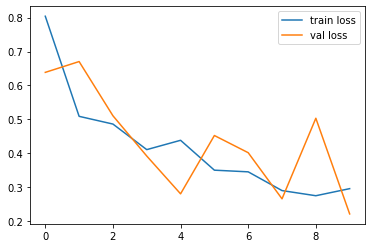

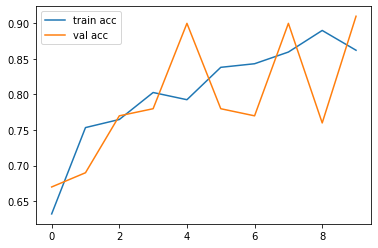

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_vgg16_1.h5')

Found 100 files belonging to 2 classes.


InvalidArgumentError: ignored

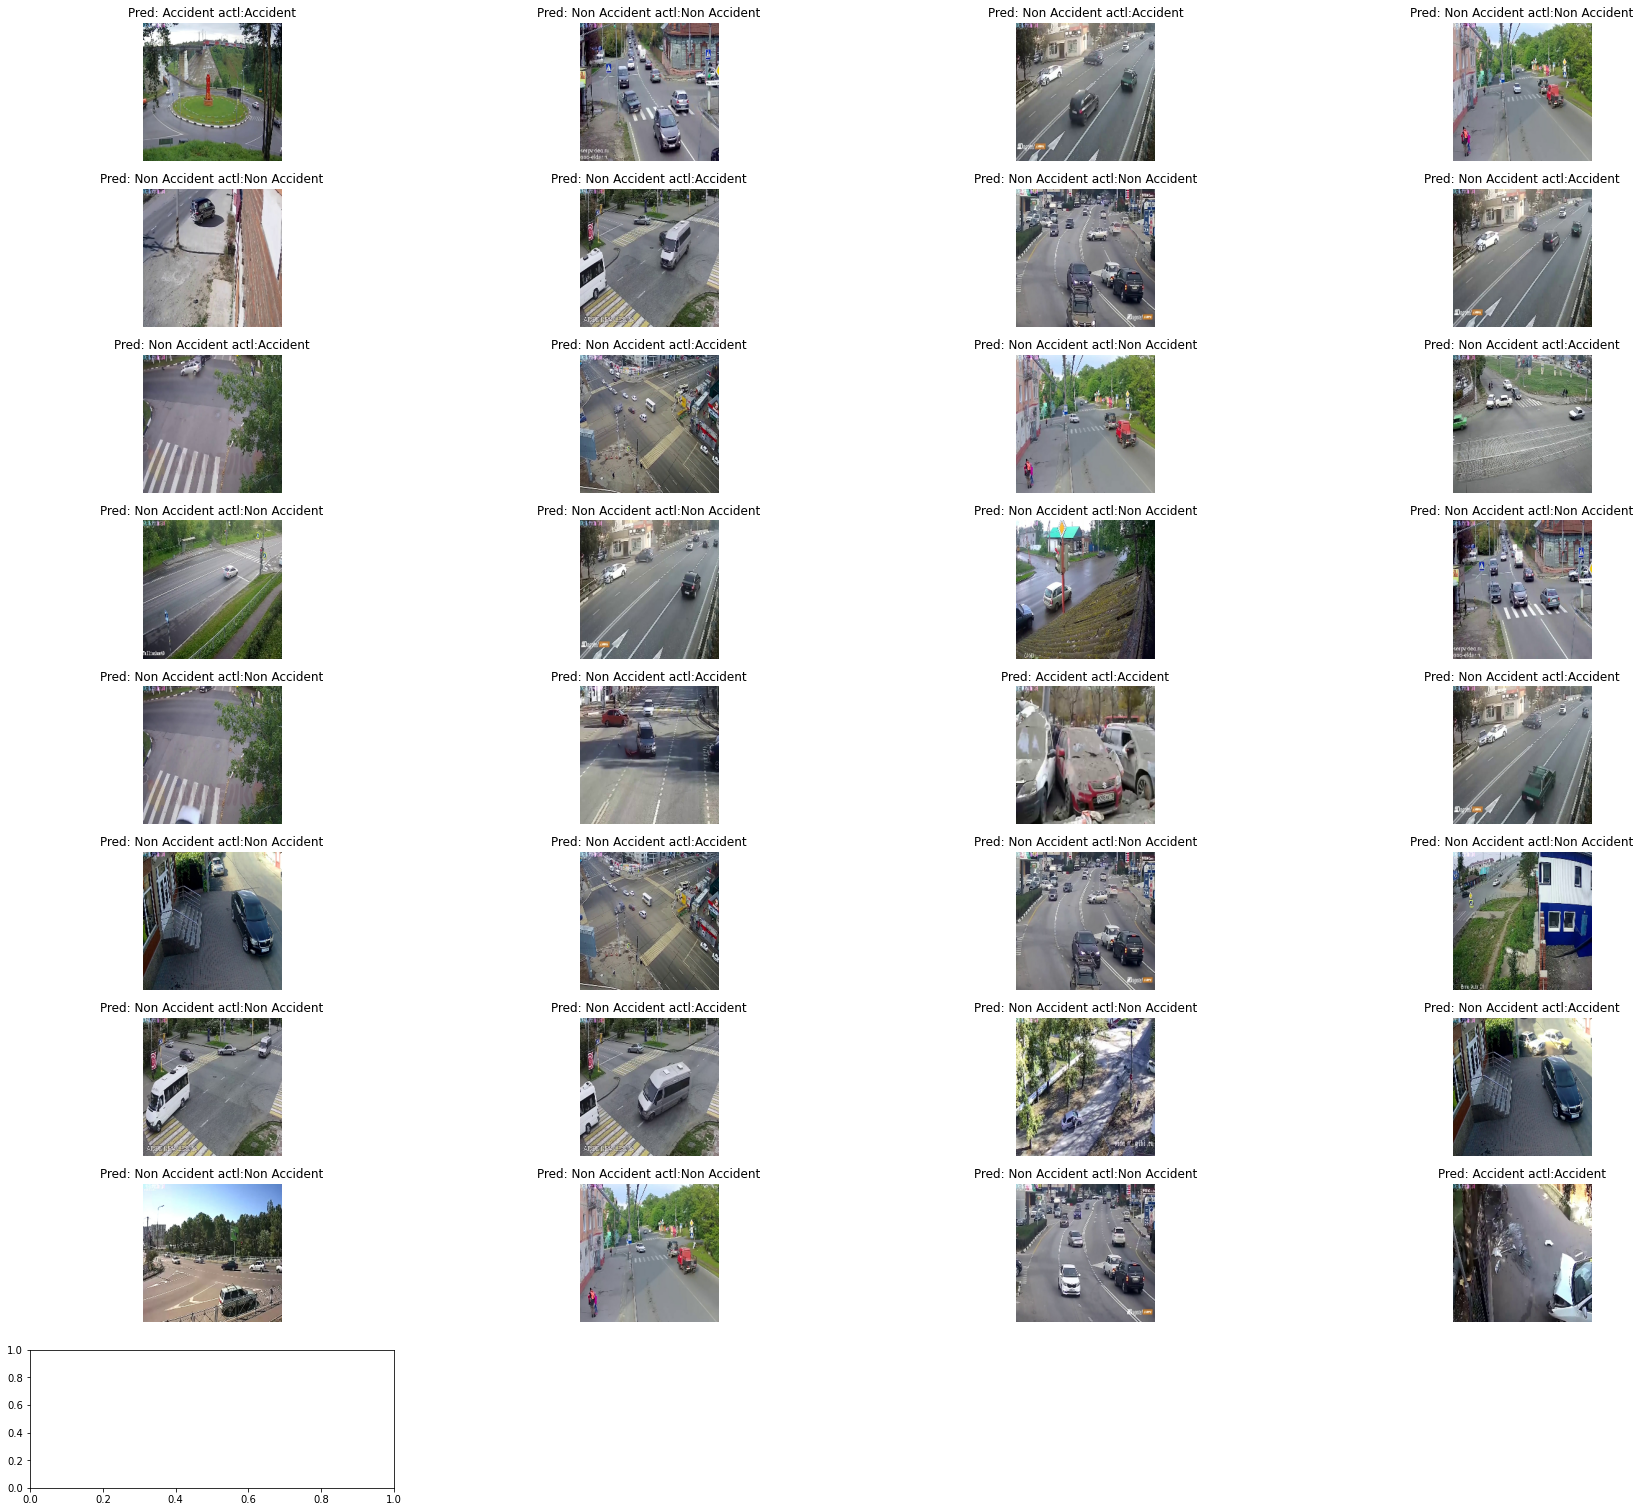

In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root + '/data/test',
    seed=42,
    image_size= IMAGE_SIZE)

class_names = testing_ds.class_names

## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        try:
          plt.imshow(images[i].numpy().astype("uint8"))
        except:
          continue
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)